# Final Project Coursera
In this project I want to explore Naples City (Italy) in order to show it is a good City for an investment in hotels and restaurant.
The mayor is trying to relaunch the city. He is in charge from **Vedere Anno**. We had several events as **Coppa Devis da Vedere** , **La coppa America** 

__Let's first of all try to import data for boroughs and neighborhoods__

In [387]:
from bs4 import BeautifulSoup
import requests # library to handle requests
import html5lib #parser
import lxml

import pandas as pd ### library for manipulating data as dataframe

import functools as ft ## function tools for reduce command

import numpy as np ## numpy array

import matplotlib ## library for plotting 
import matplotlib.pyplot as plt ## plots
import matplotlib.cm as cm
import matplotlib.colors as colorslib
%matplotlib inline

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
import shapefile

import seaborn as sns #plotting and statistics

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans # library for clustering


# Import dataframe for boroughs and neighborhoods


In [388]:
#scrape site
res_all = requests.get("https://it.wikipedia.org/wiki/Municipalit%C3%A0_di_Napoli")
soup_all = BeautifulSoup(res_all.content, features='html')

# convert in dataframe
table = soup_all.find_all('table')[0] 
df = pd.read_html(str(table))[0]
df


,Distretto,Superficie,Popolazione,Densità,Presidente,Quartieri,Mappa
0,Municipalità I,"8,80 km²",82 673,"9.553,07 ab./km²",Francesco de Giovanni di Santa Severina (Forza...,"Chiaia, Posillipo, San Ferdinando",NaN
1,Municipalità II,"4,56 km²",91 536,"20.073,68 ab./km²",Francesco Chirico,"Avvocata, Montecalvario, Pendino, Porto, Merca...",NaN
2,Municipalità III,"9,51 km²",103 633,"10.897,27 ab./km²",Ivo Poggiani (Lista DemA),"Stella, San Carlo all'Arena",NaN
3,Municipalità IV,"9,27 km²",96 078,"10.364,4 ab./km²",Giampiero Perrella,"San Lorenzo, Vicaria, Poggioreale, Zona Indust...",NaN
4,Municipalità V,"7,42 km²",119 978,"16 169,54 ab./km²",Paolo De Luca,"Vomero, Arenella",NaN
5,Municipalità VI,"19,28 km²",138 641,"7 190,92 ab./km²",Salvatore Boggia,"Ponticelli, Barra, San Giovanni a Teduccio",NaN
6,Municipalità VII,"10,26 km²",91 460,"8 914,23 ab./km²",Maurizio Moschetti,"Miano, Secondigliano, San Pietro a Patierno",NaN
7,Municipalità VIII,"17,45 km²",92 616,"5 307,51 ab./km²",Paipais Apostolos,"Piscinola, Marianella, Scampia, Chiaiano",NaN
8,Municipalità IX,"16,56 km²",106 299,"6 419,02 ab./km²",Lorenzo Giannalavigna (PD),"Soccavo, Pianura",NaN
9,Municipalità X,"14,16 km²",101 192,"7 416,38 ab./km²",Diego Civitillo,"Bagnoli, Fuorigrotta",NaN


# Import geospatial data for every borough
In the website scraped are not present the coordinates for every borough but you can find in the site for the specific borough. The site are always of same form, changing just the number of borough. In every site the coordinates are in 'span class = "geo"'. 

__In order To build the data frame let's do the following steps:__

1. take the base site type: "https://it.wikipedia.org/wiki/Municipalit%C3%A0_" + number + "_di_Napoli":

In [389]:
firstPartOfSite = "https://it.wikipedia.org/wiki/Municipalit%C3%A0_"
thirdPartOfSite = "_di_Napoli"

2. take the number of boroughs:

In [390]:
numberBoroughs = len(df)

3. do for cycle for every borough building url and scraping site:

In [391]:
latitude = [];
longitude = [];
for number in range(1, numberBoroughs+1): ### the right extreme of range is not inclusive
    ## Define url
    url = firstPartOfSite + str(number) + thirdPartOfSite
    
    ## Scrape site
    res_borough = requests.get(url)
    soup_borough = BeautifulSoup(res_borough.content, features='html')
    
    ## Get Coordinates
    coordinates = soup_borough.find_all('span', attrs={"class":"geo"})[0].text
    latLong = [float(coord) for coord in (coordinates.split('; '))]
    latitude.append(latLong[0])
    longitude.append(latLong[1])

# Build DataFrame 

In [392]:
df.drop(columns=['Presidente', 'Mappa'], inplace=True)

In [393]:
## Rename
df.columns = ['Municipality', 'Surface_km2', 'Population', 'Density_per_km2', 'Neighborhood']

## Modify Municipality
df['Municipality'] = df['Municipality'].str.replace(" ", "_")

## Modify Surface
surface_numpy = df['Surface_km2'].to_numpy()
df['Surface_km2'] = [float(num.split()[0].replace(",",".")) for num in surface_numpy]

## Modify Population
population_numpy = df['Population'].to_numpy()
df['Population'] = [float(ft.reduce(lambda x, y: x + y, num.split())) for num in population_numpy]

## Modify Density
df['Density_per_km2'] = np.around(np.divide(df['Population'].to_numpy(), df['Surface_km2'].to_numpy()), decimals = 2)

## Add numbers of Neighborhoods for descritive analyses
neighborhood_numpy = df['Neighborhood'].to_numpy()
number_Neighborhoods = [neigh.split(',') for neigh in neighborhood_numpy]
number_Neighborhoods = [len(a) for a in number_Neighborhoods]
df['number_Neighborhoods'] = number_Neighborhoods
 
## Add Latitude and Longitude
df['Latitude'] = latitude
df['Longitude'] = longitude

In [394]:
df

,Municipality,Surface_km2,Population,Density_per_km2,Neighborhood,number_Neighborhoods,Latitude,Longitude
0,Municipalità_I,8.80,82673.0,9394.66,"Chiaia, Posillipo, San Ferdinando",3,40.805556,14.203333
1,Municipalità_II,4.56,91536.0,20073.68,"Avvocata, Montecalvario, Pendino, Porto, Merca...",6,40.847645,14.261577
2,Municipalità_III,9.51,103633.0,10897.27,"Stella, San Carlo all'Arena",2,40.863290,14.255261
3,Municipalità_IV,9.27,96078.0,10364.40,"San Lorenzo, Vicaria, Poggioreale, Zona Indust...",4,40.868743,14.301424
4,Municipalità_V,7.42,119978.0,16169.54,"Vomero, Arenella",2,40.865887,14.222102
5,Municipalità_VI,19.28,138641.0,7190.92,"Ponticelli, Barra, San Giovanni a Teduccio",3,40.853699,14.332309
6,Municipalità_VII,10.26,91460.0,8914.23,"Miano, Secondigliano, San Pietro a Patierno",3,40.890017,14.263705
7,Municipalità_VIII,17.45,92616.0,5307.51,"Piscinola, Marianella, Scampia, Chiaiano",4,40.892900,14.237700
8,Municipalità_IX,16.56,106299.0,6419.02,"Soccavo, Pianura",2,40.858422,14.170289
9,Municipalità_X,14.16,101192.0,7146.33,"Bagnoli, Fuorigrotta",2,40.818117,14.163919


# Plotting Boroughs on map

In [395]:
# Initialize a map
### Use geopy to extract a coordinate for Naples address 
address = 'Napoli, Na'

geolocator = Nominatim(user_agent="my_explorer")

location = geolocator.geocode(address)
latAddress = location.latitude
longAddress = location.longitude

print('The geograpical coordinate of Naples are {}, {}.'.format(latAddress, longAddress))

The geograpical coordinate of Naples are 40.8359336, 14.2487826.


In [396]:
# create map of Naples using latitude and longitude values
map_naples = folium.Map(location=[latAddress, longAddress], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Municipality'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(map_naples)  
    
map_naples    

## Let's import shapefile

# Analisi descrittiva del dataframe

In [397]:
df.describe()

,Surface_km2,Population,Density_per_km2,number_Neighborhoods,Latitude,Longitude
count,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000
mean,11.727000,102410.60000,10187.756000,3.100000,40.856428,14.241162
std,4.838106,16340.59621,4625.415132,1.286684,0.027670,0.053602
min,4.560000,82673.00000,5307.510000,2.000000,40.805556,14.163919
25%,8.917500,91806.00000,7157.477500,2.000000,40.849159,14.208025
50%,9.885000,98635.00000,9154.445000,3.000000,40.860856,14.246481
75%,15.960000,105632.50000,10764.052500,3.750000,40.868029,14.263173
max,19.280000,138641.00000,20073.680000,6.000000,40.892900,14.332309


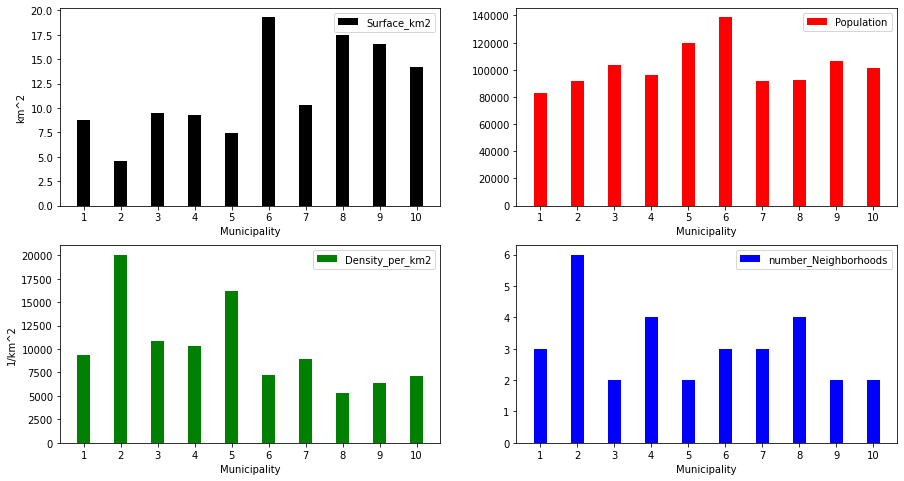

In [398]:
## Bar Plot
x = np.arange(1, len(df)+1)  # the label locations

width = 0.35  # the width of the bars

fig, axs = plt.subplots(2,2) ## Create a figure and a set of sublots
fig.set_size_inches(15, 8)
colors = ['black', 'red', 'green', 'blue']

# Plot Surface
axs[0,0].bar(x, df['Surface_km2'].to_numpy(), width, label='Surface_km2', color = colors[0])

axs[0,0].set_xlabel('Municipality')
axs[0,0].set_xticks(x)
axs[0,0].set_ylabel('km^2')
axs[0,0].legend()

# Plot Population
axs[0,1].bar(x, df['Population'].to_numpy(), width, label='Population', color = colors[1])

axs[0,1].set_xlabel('Municipality')
axs[0,1].set_xticks(x)
axs[0,1].legend()

# Plot Density
axs[1,0].bar(x, df['Density_per_km2'].to_numpy(), width, label='Density_per_km2', color = colors[2])

axs[1,0].set_xlabel('Municipality')
axs[1,0].set_xticks(x)
axs[1,0].set_ylabel('1/km^2')
axs[1,0].legend()

# Plot Number Neighborhood
axs[1,1].bar(x, df['number_Neighborhoods'].to_numpy(), width, label='number_Neighborhoods', color = colors[3])
axs[1,1].set_xlabel('Municipality')
axs[1,1].set_xticks(x)
axs[1,1].legend()


We can note that population is concentrated primarly in municipality with lower surface. So in this area there is a greater density of population and a greater number of neighborhoods (*second municipality shows 6 neighborhoods and ~20000 people per squared kilometer*)

_Let's see some scatter to better highlight these features_


Text(0, 0.5, 'Population')

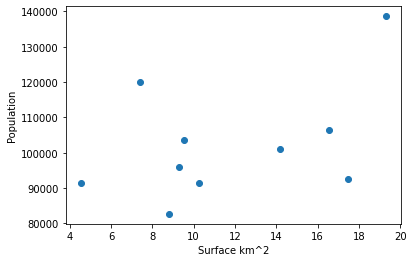

In [399]:
plt.scatter(df['Surface_km2'], df['Population'])
plt.xlabel('Surface km^2')
plt.ylabel('Population')

There is a net separation at 12 squared kilometers. Let's count the overall population at this cut value

In [400]:
dfLower = df[df['Surface_km2']<12]
populationLower = dfLower['Population'].sum()

dfUpper = df[df['Surface_km2']>12]
populationUpper = dfUpper['Population'].sum()

print("Population with in municipality with Surface lower than 12 squared kilometers: %d" % populationLower)
print("Population with in municipality with Surface greater than 12 squared kilometers: %d" % populationUpper)


Population with in municipality with Surface lower than 12 squared kilometers: 585358
Population with in municipality with Surface greater than 12 squared kilometers: 438748


Text(0, 0.5, 'Population')

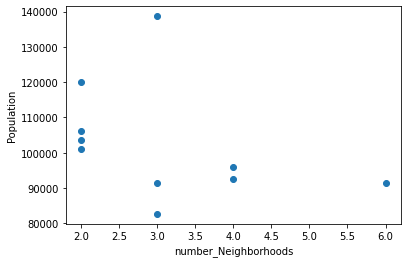

In [401]:
plt.scatter(df['number_Neighborhoods'], df['Population'])
plt.xlabel('number_Neighborhoods')
plt.ylabel('Population')

The population is primarly concentrated in municipality with low number of Neighborhoods

Text(0, 0.5, 'Surface_km2')

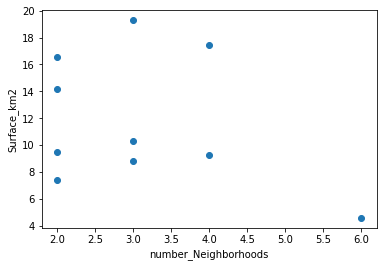

In [402]:
plt.scatter(df['number_Neighborhoods'], df['Surface_km2'])
plt.xlabel('number_Neighborhoods')
plt.ylabel('Surface_km2')

# Si prova ad estrarre i dati relativi alla temperatura

In [403]:
## Define url
url = "https://en.climate-data.org/europe/italy/campania/naples-4561/"
    
## Scrape site
res_temperature = requests.get(url)
soup_temperature = BeautifulSoup(res_temperature.content, features='html5')

## extract wiki table
table_temp = soup_temperature.find_all('table', attrs={"id":"weather_table"}) ## la table è unica

df_temp = pd.read_html(str(table_temp))[0]
df_temp = df_temp.transpose()
df_temp = df_temp.reset_index()
df_temp.drop(0, inplace = True)
df_temp = df_temp.reset_index(drop=True)
df_temp.columns = ["Month","AvgTemp_C", "MinTemp_C", "MaxTemp_C", "AvgTemp_F", "MinTemp_F", "MaxTemp_F", "Rainfall_mm"]## rename columns
df_temp[["AvgTemp_C", "MinTemp_C", "MaxTemp_C", "AvgTemp_F", "MinTemp_F", "MaxTemp_F", "Rainfall_mm"]] = df_temp[["AvgTemp_C", "MinTemp_C", "MaxTemp_C", "AvgTemp_F", "MinTemp_F", "MaxTemp_F", "Rainfall_mm"]].astype(float) ## convert numerical values to float
df_temp

,Month,AvgTemp_C,MinTemp_C,MaxTemp_C,AvgTemp_F,MinTemp_F,MaxTemp_F,Rainfall_mm
0,January,8.6,4.9,12.4,47.5,40.8,54.3,100.0
1,February,9.2,5.2,13.2,48.6,41.4,55.8,84.0
2,March,10.9,6.7,15.1,51.6,44.1,59.2,76.0
3,April,13.3,8.9,17.8,55.9,48.0,64.0,68.0
4,May,17.2,12.5,22.0,63.0,54.5,71.6,44.0
5,June,21.0,16.0,26.0,69.8,60.8,78.8,29.0
6,July,23.3,18.1,28.6,73.9,64.6,83.5,21.0
7,August,23.6,18.3,29.0,74.5,64.9,84.2,37.0
8,September,21.0,16.2,25.9,69.8,61.2,78.6,71.0
9,October,17.0,12.6,21.5,62.6,54.7,70.7,112.0


Text(0, 0.5, 'Rainfall (mm)')

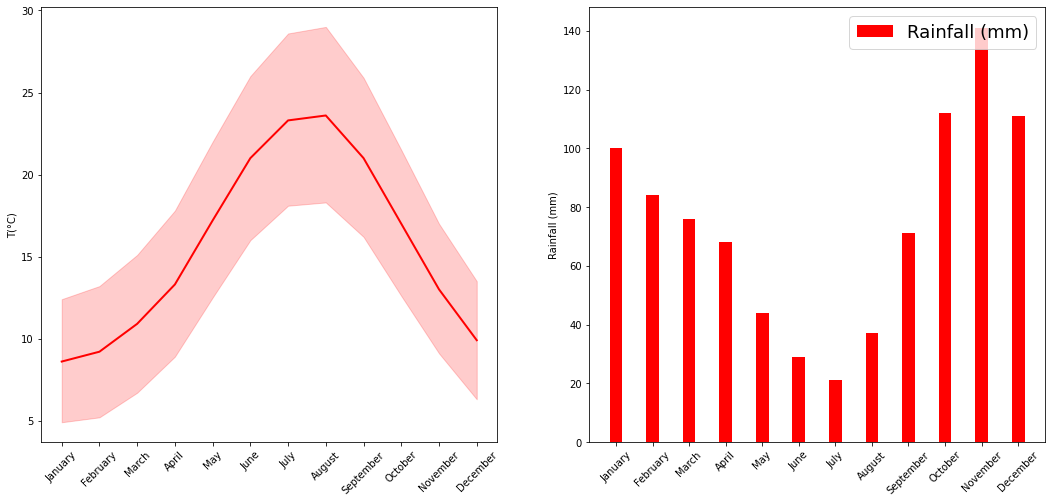

In [404]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
#LinePlot
ax1.plot(df_temp["Month"],df_temp["AvgTemp_C"], 'red', linewidth=2.0)
ax1.fill_between(df_temp["Month"], df_temp["MinTemp_C"], df_temp["MaxTemp_C"], alpha=0.2, color="red")
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel("T(°C)")

#BarPlot
ax2.bar(df_temp["Month"], df_temp["Rainfall_mm"], 0.35, label='Rainfall (mm)', color="red")
ax2.tick_params(axis='x', rotation=45)
ax2.legend(loc='upper right', fontsize = 18)
ax2.set_ylabel("Rainfall (mm)")

# Giusto per fare anche un confronto con New York per avere una idea

In [405]:
## Define url
url_nk = "https://en.climate-data.org/north-america/united-states-of-america/new-york/new-york-1091/"
    
## Scrape site
res_temperature_nk = requests.get(url_nk)
soup_temperature_nk = BeautifulSoup(res_temperature_nk.content, features='html5')

## extract wiki table
table_temp_nk = soup_temperature_nk.find_all('table', attrs={"id":"weather_table"}) ## la table è unica

df_temp_nk = pd.read_html(str(table_temp_nk))[0]
df_temp_nk = df_temp_nk.transpose()
df_temp_nk = df_temp_nk.reset_index()
df_temp_nk.drop(0, inplace = True)
df_temp_nk.columns = ["Month","AvgTemp_C", "MinTemp_C", "MaxTemp_C", "AvgTemp_F", "MinTemp_F", "MaxTemp_F", "Rainfall_mm"]## rename columns
df_temp_nk[["AvgTemp_C", "MinTemp_C", "MaxTemp_C", "AvgTemp_F", "MinTemp_F", "MaxTemp_F", "Rainfall_mm"]] = df_temp_nk[["AvgTemp_C", "MinTemp_C", "MaxTemp_C", "AvgTemp_F", "MinTemp_F", "MaxTemp_F", "Rainfall_mm"]].astype(float) ## convert numerical values to float


Text(0, 0.5, 'Rainfall (mm)')

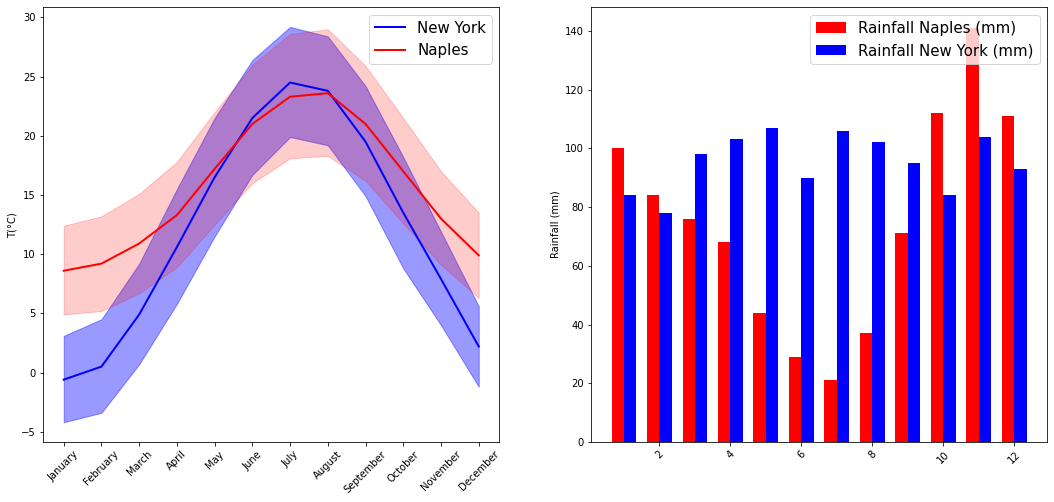

In [406]:
fig,(ax3, ax4) = plt.subplots(1, 2, figsize=(18, 8))
x = np.arange(1, 13)  # the label locations

#LinePlot
ax3.plot(df_temp_nk["Month"],df_temp_nk["AvgTemp_C"], 'blue', linewidth=2.0)
ax3.fill_between(df_temp_nk["Month"], df_temp_nk["MinTemp_C"], df_temp_nk["MaxTemp_C"], alpha=0.4, color="blue")

ax3.plot(df_temp["Month"], df_temp["AvgTemp_C"], 'red', linewidth=2.0)
ax3.fill_between(df_temp["Month"], df_temp["MinTemp_C"], df_temp["MaxTemp_C"], alpha=0.2, color="red")

ax3.tick_params(axis='x', rotation=45)
ax3.set_ylabel("T(°C)")
ax3.legend(["New York", "Naples"], fontsize = 15)

#BarPlot
width = 0.35
ax4.bar(x - width/2, df_temp["Rainfall_mm"], 0.35, label='Rainfall Naples (mm)', color="red")
ax4.bar(x + width/2, df_temp_nk["Rainfall_mm"], 0.35, label='Rainfall New York (mm)', color="blue")

ax4.tick_params(axis='x', rotation=45)

ax4.legend(loc='upper right', fontsize = 15)
ax4.set_ylabel("Rainfall (mm)")

## Nella prossima sezione si vedrà l'applicazione di Foursquare API per estrarre i locali presenti in ogni sezione 

In [407]:
# @hidden_cell
CLIENT_ID = 'SJVYFAOYIMC1JV4K5TXAO5C5DR2GEJPYNVQ00JEJEFRNIF1L' #  Foursquare ID
CLIENT_SECRET = 'SKTMQ0K2AKDPS5FFWFC5K4VUZZXSEKTR12D555T2LB1NORXT' #  Foursquare Secret
VERSION = '20180605' # Foursquare API version

**Let's explore the first Neighborhood in the dataframe**

In [408]:
neighborhood_latitude = df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Chiaia, Posillipo, San Ferdinando are 40.805556, 14.203333.


#### Now, let's get the top 100 venues that are in The Beaches within a radius of 500 meters.

## First, let's create the GET request URL


In [409]:
LIMIT = 1000 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

## Do request
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e75fd7cb4b684001b7bd247'},
 'response': {'headerLocation': 'Posillipo',
  'headerFullLocation': 'Posillipo, Naples',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 7,
  'suggestedBounds': {'ne': {'lat': 40.814556009000015,
    'lng': 14.215200920285408},
   'sw': {'lat': 40.79655599099999, 'lng': 14.191465079714593}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c12ad3682a3c9b6a128faf8',
       'name': 'Bilancione',
       'location': {'address': 'Via Posillipo, 238',
        'lat': 40.813626267021874,
        'lng': 14.207285986743608,
        'labeledLatLngs': [{'label': 'display',
          'lat': 40.813626267021874,
          'lng': 14.207285986743608}],
        'distance': 958,
        'postalCode': '80123'

The interesting information is contained in the items category

In [410]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [411]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Bilancione,Ice Cream Shop,40.813626,14.207286
1,Giuseppone A Mare,Italian Restaurant,40.802321,14.206808
2,Ristorante Reginella,Seafood Restaurant,40.812650,14.207378
3,Teatro Posillipo,Nightclub,40.803145,14.196960
4,Riva Fiorita,Harbor / Marina,40.802880,14.206820


## Explore Neighborhoods in Naples

#### Let's create a function to repeat the same process of the previous section to all the neighborhoods in Naples


In [412]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500, LIMIT = 150):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now run the above function on each neighborhood and create a new dataframe called *naples_venues*.

In [413]:
naples_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

In [414]:
naples_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Chiaia, Posillipo, San Ferdinando",40.805556,14.203333,Luoghi dell'amore di Loveville 2014 - Posillipo,40.815491,14.208596,Palace
1,"Chiaia, Posillipo, San Ferdinando",40.805556,14.203333,Bilancione,40.813626,14.207286,Ice Cream Shop
2,"Chiaia, Posillipo, San Ferdinando",40.805556,14.203333,Elettroforno,40.814523,14.207824,Fast Food Restaurant
3,"Chiaia, Posillipo, San Ferdinando",40.805556,14.203333,Giuseppone A Mare,40.802321,14.206808,Italian Restaurant
4,"Chiaia, Posillipo, San Ferdinando",40.805556,14.203333,Miranapoli,40.814725,14.206072,Café
...,...,...,...,...,...,...,...
261,"Bagnoli, Fuorigrotta",40.818117,14.163919,Pontile Nord,40.810594,14.164124,Pier
262,"Bagnoli, Fuorigrotta",40.818117,14.163919,Hotel Terme di Agnano,40.827031,14.170536,Hotel
263,"Bagnoli, Fuorigrotta",40.818117,14.163919,Mini Hotel Pozzuoli,40.821134,14.149921,Hotel
264,"Bagnoli, Fuorigrotta",40.818117,14.163919,Ristorante Le due Palme,40.828401,14.169213,Restaurant


Let's check how many venues were returned for each neighborhood

In [415]:
naples_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Avvocata, Montecalvario, Pendino, Porto, Mercato, San Giuseppe",100,100,100,100,100,100
"Bagnoli, Fuorigrotta",29,29,29,29,29,29
"Chiaia, Posillipo, San Ferdinando",15,15,15,15,15,15
"Miano, Secondigliano, San Pietro a Patierno",7,7,7,7,7,7
"Piscinola, Marianella, Scampia, Chiaiano",7,7,7,7,7,7
"Ponticelli, Barra, San Giovanni a Teduccio",8,8,8,8,8,8
"San Lorenzo, Vicaria, Poggioreale, Zona Industriale",10,10,10,10,10,10
"Soccavo, Pianura",5,5,5,5,5,5
"Stella, San Carlo all'Arena",72,72,72,72,72,72


##  Analyze Each Neighborhood

In [416]:
# one hot encoding
naples_onehot = pd.get_dummies(naples_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
naples_onehot['Neighborhood'] = naples_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [naples_onehot.columns[-1]] + list(naples_onehot.columns[:-1])
naples_onehot = naples_onehot[fixed_columns]

naples_onehot.tail()

,Neighborhood,Art Gallery,Art Museum,Bakery,Bar,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Bookstore,...,Spa,Stadium,Steakhouse,Supermarket,Theater,Track,Train Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Yoga Studio
261,"Bagnoli, Fuorigrotta",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
262,"Bagnoli, Fuorigrotta",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
263,"Bagnoli, Fuorigrotta",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
264,"Bagnoli, Fuorigrotta",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
265,"Bagnoli, Fuorigrotta",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [417]:
naples_grouped = naples_onehot.groupby('Neighborhood').mean().reset_index()
naples_grouped

,Neighborhood,Art Gallery,Art Museum,Bakery,Bar,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Bookstore,...,Spa,Stadium,Steakhouse,Supermarket,Theater,Track,Train Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Yoga Studio
0,"Avvocata, Montecalvario, Pendino, Porto, Merca...",0.000000,0.030000,0.010000,0.020000,0.000000,0.000000,0.01,0.000000,0.02,...,0.000000,0.000,0.000000,0.000000,0.010000,0.000,0.000000,0.020000,0.000000,0.000000
1,"Bagnoli, Fuorigrotta",0.000000,0.000000,0.000000,0.000000,0.000000,0.034483,0.00,0.000000,0.00,...,0.034483,0.000,0.000000,0.034483,0.034483,0.000,0.000000,0.000000,0.000000,0.000000
2,"Chiaia, Posillipo, San Ferdinando",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,...,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000000,0.066667,0.000000,0.000000
3,"Miano, Secondigliano, San Pietro a Patierno",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,...,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.142857
4,"Piscinola, Marianella, Scampia, Chiaiano",0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.00,0.000000,0.00,...,0.000000,0.000,0.000000,0.142857,0.142857,0.000,0.142857,0.000000,0.000000,0.000000
5,"Ponticelli, Barra, San Giovanni a Teduccio",0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,...,0.000000,0.125,0.000000,0.000000,0.000000,0.125,0.000000,0.000000,0.000000,0.000000
6,"San Lorenzo, Vicaria, Poggioreale, Zona Indust...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,...,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
7,"Soccavo, Pianura",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,...,0.000000,0.000,0.000000,0.200000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
8,"Stella, San Carlo all'Arena",0.013889,0.027778,0.013889,0.013889,0.000000,0.000000,0.00,0.013889,0.00,...,0.000000,0.000,0.000000,0.013889,0.041667,0.000,0.000000,0.041667,0.013889,0.000000
9,"Vomero, Arenella",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,...,0.000000,0.000,0.076923,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000


#### Let's print each neighborhood along with the top 5 most common venues

In [418]:
num_top_venues = 5

for hood in naples_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = naples_grouped[naples_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Avvocata, Montecalvario, Pendino, Porto, Mercato, San Giuseppe----
                venue  freq
0         Pizza Place  0.20
1               Hotel  0.13
2  Italian Restaurant  0.09
3               Plaza  0.08
4       Historic Site  0.06


----Bagnoli, Fuorigrotta----
                venue  freq
0               Hotel  0.24
1          Restaurant  0.10
2           Nightclub  0.07
3  Italian Restaurant  0.07
4        Concert Hall  0.03


----Chiaia, Posillipo, San Ferdinando----
                venue  freq
0  Italian Restaurant  0.27
1          Restaurant  0.13
2  Seafood Restaurant  0.13
3                Café  0.13
4      Ice Cream Shop  0.07


----Miano, Secondigliano, San Pietro a Patierno----
         venue  freq
0        Hotel  0.29
1  Pizza Place  0.29
2         Park  0.14
3        Plaza  0.14
4  Yoga Studio  0.14


----Piscinola, Marianella, Scampia, Chiaiano----
              venue  freq
0     Metro Station  0.29
1              Park  0.14
2  Basketball Court  0.14
3     Train Sta

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [419]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [420]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = naples_grouped['Neighborhood']

for ind in np.arange(naples_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(naples_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Avvocata, Montecalvario, Pendino, Porto, Merca...",Pizza Place,Hotel,Italian Restaurant,Plaza,Dessert Shop,Historic Site,Café,Art Museum,Ice Cream Shop,Bookstore
1,"Bagnoli, Fuorigrotta",Hotel,Restaurant,Nightclub,Italian Restaurant,Café,Concert Hall,Movie Theater,Multiplex,Light Rail Station,Chinese Restaurant
2,"Chiaia, Posillipo, San Ferdinando",Italian Restaurant,Café,Restaurant,Seafood Restaurant,Ice Cream Shop,Nightclub,Fast Food Restaurant,Palace,Trattoria/Osteria,Fish Market
3,"Miano, Secondigliano, San Pietro a Patierno",Hotel,Pizza Place,Yoga Studio,Plaza,Park,Diner,Concert Hall,Construction & Landscaping,Convenience Store,Deli / Bodega
4,"Piscinola, Marianella, Scampia, Chiaiano",Metro Station,Park,Train Station,Theater,Supermarket,Basketball Court,Diner,Concert Hall,Construction & Landscaping,Convenience Store
5,"Ponticelli, Barra, San Giovanni a Teduccio",Park,Construction & Landscaping,Bakery,Track,Ice Cream Shop,Stadium,Intersection,Café,Electronics Store,Convenience Store
6,"San Lorenzo, Vicaria, Poggioreale, Zona Indust...",Pizza Place,Light Rail Station,Café,Shop & Service,Hotel,Hotel Bar,Diner,Market,Convenience Store,Deli / Bodega
7,"Soccavo, Pianura",Cocktail Bar,Gym,Convenience Store,Supermarket,Light Rail Station,Fast Food Restaurant,Construction & Landscaping,Deli / Bodega,Dessert Shop,Diner
8,"Stella, San Carlo all'Arena",Pizza Place,Hotel,Historic Site,Plaza,Trattoria/Osteria,Italian Restaurant,Theater,Art Museum,Park,Dessert Shop
9,"Vomero, Arenella",Smoke Shop,Pizza Place,Clothing Store,Hotel,Fast Food Restaurant,Electronics Store,Dessert Shop,Park,Café,Gym


# Cluster Neighborhoods

## After superimposed Data on map let's define the number of cluster

In [421]:
kclusters = 6

naples_grouped_clustering = naples_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(naples_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 4, 0, 3, 5, 1, 2, 1, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [422]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

naples_merged = df

# merge naples_grouped with naples_data to add latitude/longitude for each neighborhood
naples_merged = naples_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

naples_merged.head() # check the last columns!

,Municipality,Surface_km2,Population,Density_per_km2,Neighborhood,number_Neighborhoods,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Municipalità_I,8.80,82673.0,9394.66,"Chiaia, Posillipo, San Ferdinando",3,40.805556,14.203333,4,Italian Restaurant,Café,Restaurant,Seafood Restaurant,Ice Cream Shop,Nightclub,Fast Food Restaurant,Palace,Trattoria/Osteria,Fish Market
1,Municipalità_II,4.56,91536.0,20073.68,"Avvocata, Montecalvario, Pendino, Porto, Merca...",6,40.847645,14.261577,1,Pizza Place,Hotel,Italian Restaurant,Plaza,Dessert Shop,Historic Site,Café,Art Museum,Ice Cream Shop,Bookstore
2,Municipalità_III,9.51,103633.0,10897.27,"Stella, San Carlo all'Arena",2,40.863290,14.255261,1,Pizza Place,Hotel,Historic Site,Plaza,Trattoria/Osteria,Italian Restaurant,Theater,Art Museum,Park,Dessert Shop
3,Municipalità_IV,9.27,96078.0,10364.40,"San Lorenzo, Vicaria, Poggioreale, Zona Indust...",4,40.868743,14.301424,1,Pizza Place,Light Rail Station,Café,Shop & Service,Hotel,Hotel Bar,Diner,Market,Convenience Store,Deli / Bodega
4,Municipalità_V,7.42,119978.0,16169.54,"Vomero, Arenella",2,40.865887,14.222102,1,Smoke Shop,Pizza Place,Clothing Store,Hotel,Fast Food Restaurant,Electronics Store,Dessert Shop,Park,Café,Gym


In [423]:
neighborhoods_venues_sorted

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,"Avvocata, Montecalvario, Pendino, Porto, Merca...",Pizza Place,Hotel,Italian Restaurant,Plaza,Dessert Shop,Historic Site,Café,Art Museum,Ice Cream Shop,Bookstore
1,1,"Bagnoli, Fuorigrotta",Hotel,Restaurant,Nightclub,Italian Restaurant,Café,Concert Hall,Movie Theater,Multiplex,Light Rail Station,Chinese Restaurant
2,4,"Chiaia, Posillipo, San Ferdinando",Italian Restaurant,Café,Restaurant,Seafood Restaurant,Ice Cream Shop,Nightclub,Fast Food Restaurant,Palace,Trattoria/Osteria,Fish Market
3,0,"Miano, Secondigliano, San Pietro a Patierno",Hotel,Pizza Place,Yoga Studio,Plaza,Park,Diner,Concert Hall,Construction & Landscaping,Convenience Store,Deli / Bodega
4,3,"Piscinola, Marianella, Scampia, Chiaiano",Metro Station,Park,Train Station,Theater,Supermarket,Basketball Court,Diner,Concert Hall,Construction & Landscaping,Convenience Store
5,5,"Ponticelli, Barra, San Giovanni a Teduccio",Park,Construction & Landscaping,Bakery,Track,Ice Cream Shop,Stadium,Intersection,Café,Electronics Store,Convenience Store
6,1,"San Lorenzo, Vicaria, Poggioreale, Zona Indust...",Pizza Place,Light Rail Station,Café,Shop & Service,Hotel,Hotel Bar,Diner,Market,Convenience Store,Deli / Bodega
7,2,"Soccavo, Pianura",Cocktail Bar,Gym,Convenience Store,Supermarket,Light Rail Station,Fast Food Restaurant,Construction & Landscaping,Deli / Bodega,Dessert Shop,Diner
8,1,"Stella, San Carlo all'Arena",Pizza Place,Hotel,Historic Site,Plaza,Trattoria/Osteria,Italian Restaurant,Theater,Art Museum,Park,Dessert Shop
9,1,"Vomero, Arenella",Smoke Shop,Pizza Place,Clothing Store,Hotel,Fast Food Restaurant,Electronics Store,Dessert Shop,Park,Café,Gym


# Plotting clusters on Map

In [424]:
# create map
map_clusters = folium.Map(location=[latAddress, longAddress], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colorslib.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(naples_merged['Latitude'], naples_merged['Longitude'], naples_merged['Neighborhood'], naples_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

# Una prossima idea potrebbe ssere quella di analizzare ogni cluster, capire quelli più interessanti per certe caratteristiche. 

# cluster 1

In [425]:
naples_merged.loc[naples_merged['Cluster Labels'] == 0, naples_merged.columns[[1] + list(range(5, naples_merged.shape[1]))]]

,Surface_km2,number_Neighborhoods,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,10.26,3,40.890017,14.263705,0,Hotel,Pizza Place,Yoga Studio,Plaza,Park,Diner,Concert Hall,Construction & Landscaping,Convenience Store,Deli / Bodega


# Cluster 2

In [426]:
naples_merged.loc[naples_merged['Cluster Labels'] == 1, naples_merged.columns[[1] + list(range(5, naples_merged.shape[1]))]]

,Surface_km2,number_Neighborhoods,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,4.56,6,40.847645,14.261577,1,Pizza Place,Hotel,Italian Restaurant,Plaza,Dessert Shop,Historic Site,Café,Art Museum,Ice Cream Shop,Bookstore
2,9.51,2,40.863290,14.255261,1,Pizza Place,Hotel,Historic Site,Plaza,Trattoria/Osteria,Italian Restaurant,Theater,Art Museum,Park,Dessert Shop
3,9.27,4,40.868743,14.301424,1,Pizza Place,Light Rail Station,Café,Shop & Service,Hotel,Hotel Bar,Diner,Market,Convenience Store,Deli / Bodega
4,7.42,2,40.865887,14.222102,1,Smoke Shop,Pizza Place,Clothing Store,Hotel,Fast Food Restaurant,Electronics Store,Dessert Shop,Park,Café,Gym
9,14.16,2,40.818117,14.163919,1,Hotel,Restaurant,Nightclub,Italian Restaurant,Café,Concert Hall,Movie Theater,Multiplex,Light Rail Station,Chinese Restaurant
